## Imports

In [1]:
import os
import sys
import json
import gc
import re
from tqdm import notebook as tqdm
import pickle
import itertools
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from stop_words import RUSSIAN_NAMES, RUSSIAN_SURNAMES, RUSSIAN_STOP_WORDS, ENG_STOP_WORDS

nltk.data.path.append('./nltk_data/')

SEP_TOKEN = '<sep>'

In [2]:
sns.set(font_scale=1.2, palette='Set2')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 123

## EDA

In [6]:
with open('../data/0x1tv-dataset.pickle', 'rb') as fd:
    data = pickle.load(fd)
    
data

{'articles': [{'title': '0MQ — Сокеты на стероидах (Сергей Гулько, OSDN-UA-2012)',
   'text': '== Аннотация ==\n;Докладчик: {{Speaker|Сергей Гулько}}\n<blockquote>\n</blockquote>\n\n== Видео ==\n\n{{vimeoembed|50976326|800|500}}\n{{youtubelink|C0IpZrOo6MY}}{{letscomment}}\n\n{{ftp-osdn-ua-2012|0mq-sockets-on-steroids-gulko}}\n\n\n<!-- pollholder --> \n\n\n\n\n\n\n\n\n\n\n== Слайды ==\n[[File:0MQ — Сокеты на стероидах (Сергей Гулько, OSDN-UA-2012).pdf|left|page=-|256px]]\n\n{{----}}\n== Примечания и отзывы ==\n<!-- <blockquote>[©]</blockquote> -->\n\n{{include-review|OSDN-UA-2012 (Обзор Стаса Фомина)/0MQ — Сокеты на стероидах}}\n\n<references/>\n\n[[Category:OSDN-UA-2012]]\n\n\n[[Category:Очереди]]\n[[Category:Open-source projects]]\n<!-- topub -->\n{{stats|disqus_comments=0|refresh_time=2019-09-05T20:29:20.057523|vimeo_comments=0|vimeo_plays=449|youtube_comments=0|youtube_plays=190}}',
   'categories': ['Категория:HasSpeaker',
    'Категория:OSDN-UA-2012',
    'Категория:Open-source pr

In [7]:
data.keys(), len(data['articles']), len(data['categories'])

(dict_keys(['articles', 'categories']), 2541, 2107)

In [8]:
data['articles'][:5]

[{'title': '0MQ — Сокеты на стероидах (Сергей Гулько, OSDN-UA-2012)',
  'text': '== Аннотация ==\n;Докладчик: {{Speaker|Сергей Гулько}}\n<blockquote>\n</blockquote>\n\n== Видео ==\n\n{{vimeoembed|50976326|800|500}}\n{{youtubelink|C0IpZrOo6MY}}{{letscomment}}\n\n{{ftp-osdn-ua-2012|0mq-sockets-on-steroids-gulko}}\n\n\n<!-- pollholder --> \n\n\n\n\n\n\n\n\n\n\n== Слайды ==\n[[File:0MQ — Сокеты на стероидах (Сергей Гулько, OSDN-UA-2012).pdf|left|page=-|256px]]\n\n{{----}}\n== Примечания и отзывы ==\n<!-- <blockquote>[©]</blockquote> -->\n\n{{include-review|OSDN-UA-2012 (Обзор Стаса Фомина)/0MQ — Сокеты на стероидах}}\n\n<references/>\n\n[[Category:OSDN-UA-2012]]\n\n\n[[Category:Очереди]]\n[[Category:Open-source projects]]\n<!-- topub -->\n{{stats|disqus_comments=0|refresh_time=2019-09-05T20:29:20.057523|vimeo_comments=0|vimeo_plays=449|youtube_comments=0|youtube_plays=190}}',
  'categories': ['Категория:HasSpeaker',
   'Категория:OSDN-UA-2012',
   'Категория:Open-source projects',
   'Кате

In [9]:
data['categories'][:5]

[{'title': '.NET',
  'text': '\n\n[[Категория:Программирование]]\n\n{{stats|disqus_comments=1|median_plays=209|refresh_time=2019-09-06T15:28:34.686454|vimeo_comments=0|vimeo_plays=2072|youtube_comments=3|youtube_plays=442}}\n\n\n\n\n\n\n\n\n<!-- Most Interested BEGIN-->\n\n\n<small>\nMost popular talks:\n* [[Навыки .NET-разработчика глазами зарубежных и российских работодателей (Алексей Воронин, SkillsWiki, 2015-04-30)]]\n* [[Resharper изнутри - многопоточность, структуры данных, memory traffic (Кирилл Скрыган, SECR-2014)]]\n</small>\n<!-- Most Interested END-->',
  'categories': ['Категория:Программирование']},
 {'title': '1C',
  'text': 'Доклады про продукты 1C.\n\n\n\n<!-- topub -->\n{{stats|disqus_comments=7|median_plays=367|refresh_time=2019-09-05T22:27:03.679656|vimeo_comments=0|vimeo_plays=1011|youtube_comments=0|youtube_plays=121}}\n\n\n\n\n\n<!-- Most Interested BEGIN-->\n\n\n<small>\nMost popular talks:\n* [[Прямая выгода BigData для бизнеса (использование сервисов BigData в 

In [10]:
obj = data['articles'][1765]
print(obj['title'])
print('='*80)
print(obj['text'])

Потоковая репликация в PostgreSQL (Алексей Лесовский, SECON-2017)
;{{SpeakerInfo}}: {{Speaker|Алексей Лесовский}}
<blockquote>
Одной из многих сильных сторон PostgreSQL является ее потоковая репликация - прорывная технология благодаря которой PostgreSQL перешел на качественно новый уровень. На сегодня потоковая репликация является компонентом любого постгресового сетапа и это благодаря её высокой производительности, легкости в настройке и почти неограниченной масштабируемости. Более того с момента ее появления, потоковая репликация продолжает дальнейшее развитие и от релиза к релизу обретает новые функции и возможности - такие как каскадная репликация, слоты репликации, логическая репликация и многое другое.

Из доклада вы узнаете о том, как устроена потоковая репликация снаружи и внутри, и о практических аспектах эксплуатации потоковой репликации включая такие вещи как настройка, сопровождение, мониторинг, поиск и устранение проблем. Доклад будет полезен техническим специалистам кто п

### `data['articles']` info

Bad examples:
- 120 (no annotation!!! valuable -- title + slides.filename in '== Слайды ==')
- 150 (the same shit)
- 210 (has annotation, no slides.filename)
- 1943 (no `</blockquote>`)

Interesting examples:
- 1023 (== Расширенные тезисы == в латехе, лул; end `...`)
- 194 (== Thesis ==, end `...`)
- 2011 (== Тезисы == `<latex>`) 
- 198 (in data['articles'], `== Майндмап ==
[[File:Frontier architecture — куда движется корпоративная архитектура (Евгений Кривошеев, AgileDays-2015).svg|left|page=-|800px]]`)

Questions:
- How often `title` == `slides.filename`?
- Can I exploit number of views, comments? Example: `
{{stats|disqus_comments=2|refresh_time=2019-09-05T22:04:41.657063|vimeo_comments=0|vimeo_plays=141|youtube_comments=0|youtube_plays=31}}
`

Slides:
- ```{{SlidesSection}}
[[File:Гиперконтекстность в Яндекс.Навигаторе — как мы до этого дошли (Наталья Тумашева, ProductCampMinsk-2018).pdf|left|page=-|300px]]

{{----}}
[[File:{{#setmainimage:Гиперконтекстность в Яндекс.Навигаторе — как мы до этого дошли (Наталья Тумашева, ProductCampMinsk-2018)!.jpg}}|center|640px]]
{{LinksSection}}```

- ```[[Файл:DVCS как конвейер IT-производства (Артур Орлов, ADD-2012).pdf|left|page=-|256px]]```
- 

## Text preprocessing

Смотрим на распределение секций внутри текста.

Секция -- всё, что обёрнуто в `==`

Из примеров выше: `== Майндмап ==`, `== Аннотация ==`, `== Видео ==`

Далее фильтруем по числу документов в секции: их должно быть не менее 20.

В конце сортируем по числу документов в секции.

In [9]:
def extract_categories(text):
    pattern = r'==\s*(.*?)\s*=='
    matches = re.findall(pattern, text)
    categories = [match.strip('= ') for match in matches]
    categories = list(filter(lambda x: len(x) > 0, categories))
    return categories


categories_stats = {}

for ind, elem in enumerate(data['articles']): 
    categories = extract_categories(elem['text'])
    
    for category in categories: 
        if category not in categories_stats:
            categories_stats[category] = []
        else:
            categories_stats[category].append(ind)

categories_stats = list(filter(lambda x: len(x[1]) >= 20, categories_stats.items()))
categories_stats = sorted(categories_stats, key=lambda x: len(x[1]), reverse=True)

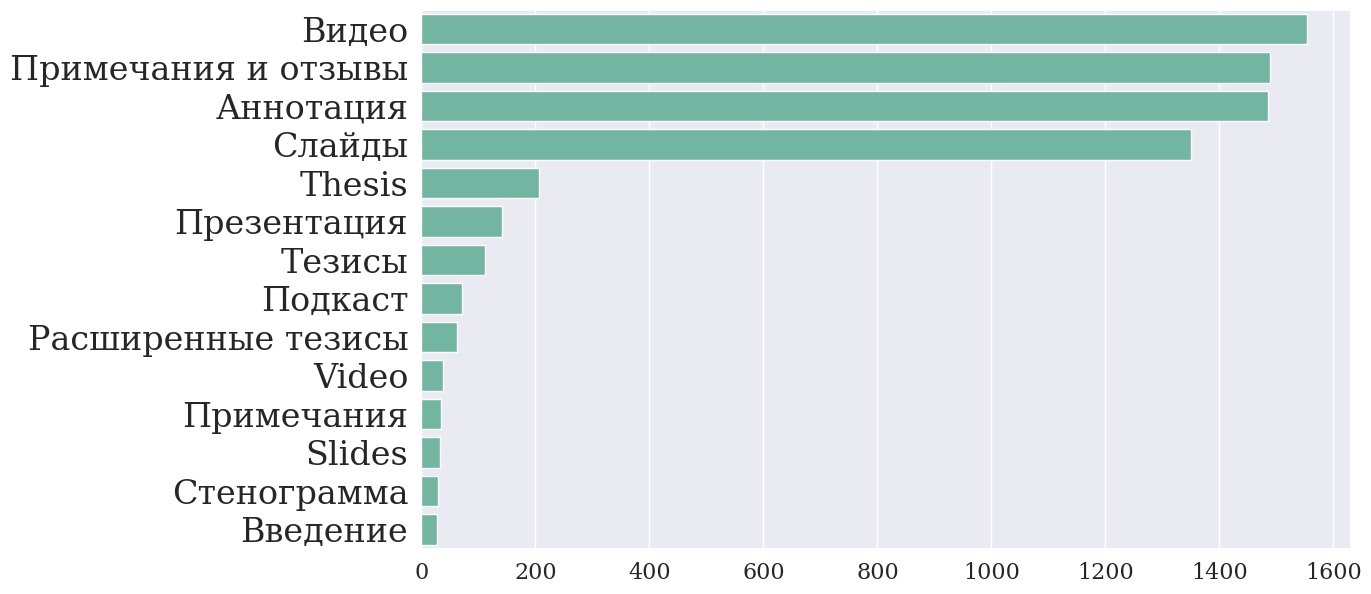

In [10]:
TOP_K = 20

sns.barplot(
    y=[x[0] for x in categories_stats[:TOP_K]],
    x=[len(x[1]) for x in categories_stats[:TOP_K]],
)
plt.show()

**Вывод**: будем брать информацию из следующих секций:
- Аннотация
- Thesis
- Тезисы
- Расширенные тезисы

Остальные секции дропаем ввиду их неинформативности ИЛИ они являются подсекцией для других секций (например, `=== Введение ===` -- подсекция для `== Тезисы ==`). ыукаиир nejbfjesb a

Парсим эти секции

In [11]:
def get_min_position(*positions):
    return min([pos for pos in positions if pos >= 0], default=len(data))

def extract_section_text(data, section_name):
    if section_name == 'Аннотация':
        blockquote_pattern = r'<blockquote>(.*?)</blockquote>'
        match = re.search(blockquote_pattern, data, re.DOTALL)
        return match.group(1).strip() if match else None
    
    section_pattern = fr'==\s*{re.escape(section_name)}\s*=='
    section_start = re.search(section_pattern, data)
    
    if not section_start:
        return None
   
    position = section_start.end()

    # Look for stop tokens and the start of next sections
    stop_tokens = ['{{----}}', '{{LinksSection}}', '== Примечания и отзывы ==']
    ends = [data.find(token, position) for token in stop_tokens]
    end_position = get_min_position(*ends)
    
    if end_position != len(data):
        return data[position:end_position].strip()
    
    return data[position:].strip()

def extract_sections(data):
    sections = ['Аннотация', 'Thesis', 'Тезисы', 'Расширенные тезисы']
    extracted_texts = {section: extract_section_text(data, section) for section in sections}
    return extracted_texts


extract_sections(data['articles'][133]['text'])

{'Аннотация': 'Modern Web is barely customizable. Most web designers try really hard to make their websites look the same for all users on all OSes and browsers and they try to eliminate any browser-specific behavior. This includes: font, font size, button placement guidelines (close button on the right or on the left, OK, Cancel buttons order and so on) and colors. We will concentrate on one problem: color customizability. People may want to override page colors for a variety of reasons: accessibility, preference to work in a dark room or just taste. But this is more complicated task rather than applying custom CSS with few overrides\n\n----\n\nКастомизируемость современного веба оставляет желать лучшего. Большинство веб-дизайнеров стараются, чтобы их веб-сайты выглядели одинаково у всех пользователей независимо от их операционных систем, браузеров и, как следствие, их предпочтений. Но потребность в кастомизации есть. Например, не всегда стандартный размер шрифта подходит всем пользов

Правда ли, что для секций `'Thesis', 'Тезисы', 'Расширенные тезисы'` достаточно следующих стоп-токенов:
[`{{----}}`, `{{LinksSection}}`, `== Примечания и отзывы ==`]

Ответ: ДА

In [12]:
def get_min_position(*positions):
    return min([elem for elem in positions if elem >= 0], default=0)

k_documents_with_thesis = 0
k_with_founded_thesis_end = 0

for ind, elem in enumerate(data['articles']):
    text = elem['text']
    categories = extract_categories(elem['text'])
    
    if 'Thesis' in categories or 'Тезисы' in categories or 'Расширенные тезисы' in categories:
        k_documents_with_thesis += 1
        position = get_min_position(text.find('Thesis'), text.find('Тезисы'), text.find('Расширенные тезисы'))
        end_position = get_min_position(
            text[position:].find('{{----}}'),
            text[position:].find('{{LinksSection}}'),
            text[position:].find('== Примечания и отзывы ==')
        )
        if end_position != 0:
            k_with_founded_thesis_end += 1


k_documents_with_thesis,  k_with_founded_thesis_end

(382, 382)

Верно ли, что НЕТ документов, в которых есть хотя бы 2 из 3-х вышеперечисленных секций с тезисами?

Ответ: ДА

In [13]:
for ind, elem in enumerate(data['articles']):
    text = elem['text']
    categories = extract_categories(elem['text'])
    
    val_1 = 'Thesis' in categories
    val_2 = 'Тезисы' in categories
    val_3 = 'Расширенные тезисы' in categories
    
    if val_1 + val_2 + val_3 > 1:
        print('False')
        break
else:
    print('True')

True


По итогу, оставляем 3 домена: заголовок, аннотация и тезисы

In [14]:
def coalesce(dct, keys):
    for key in keys:
        if dct[key] is not None or len(dct[key]) > 0:
            return dct[key]
    return None


def parse_document(doc):
    parsed_doc = dict()
    parsed_doc['title'] = doc['title']
    
    sections_data = extract_sections(doc['text'])
    parsed_doc['annotation'] = sections_data['Аннотация']
    parsed_doc['thesis'] = coalesce(sections_data, ['Thesis', 'Тезисы', 'Расширенные тезисы'])
    
    return parsed_doc

Парсим ФИО докладчиков

In [15]:
def speaker_detect(text):
    speakers = re.findall('(?<={{Speaker\|).*(?=}})', text)
    preproc_speakers = []
    for speaker in speakers:
        preproc_speakers.extend(speaker.split('|'))
    return preproc_speakers


all_speakers = [speaker_detect(text['text']) for text in data['articles']]

print('Число докладов без спикеров:', len(list(filter(lambda x: len(x) == 0, all_speakers))))
print('Число докладов с одним спикером:', len(list(filter(lambda x: len(x) == 1, all_speakers))))
print('Число докладов с двумя спикерами:', len(list(filter(lambda x: len(x) == 2, all_speakers))))
print('Число докладов с не менее тремя спикерами:', len(list(filter(lambda x: len(x) >= 3, all_speakers))))

Число докладов без спикеров: 74
Число докладов с одним спикером: 2313
Число докладов с двумя спикерами: 119
Число докладов с не менее тремя спикерами: 35


Смотрим на примеры таких сэмплов

Без спикера

In [16]:
i = 0
print('=== Без спикера ===')
for text in data['articles']:
    speaker = speaker_detect(text['text'])
    
    if len(speaker) == 0:
        i += 1
        print(text['title'])
        print(text['text'])
        print(text['categories'])
        print('='*80)
    
    if i == 5:
        break

=== Без спикера ===
Agile in Investment Banking (Сергей Евтушенко, AgileDays-2011)/Заметки Стаса Фомина
Название надо немного уточнить — конечно, речь не идет о том, чтобы гонять на скрам-митинги самих банкиров,
речь идет о разработке систем для инвестиционного банкинга, это корпоративная разработка характеризуемая:
* высокими
** нагрузками (а вообще, финансовый highload не так часто встречается в корпоративщине), т.е. и быстрые очереди сообщений, и хитрая бизнес-логика, и мощное железо, и критичность ошибок и все это в одном флаконе.
** зарплатами. Причем при наборе разработчиков очень требуют опыт разработки приложений для инвестбанкинга.

В этой области работает широко известный в узких кругах [http://lurkmore.ru/%D0%A3%D0%BC%D0%BF%D1%83%D1%82%D1%83%D0%BD Умпутуном],
и работал печально известный [http://www.linkedin.com/in/aleynikov Сергей Алейников], который променял ежегодние $400×10³ на 8 лет тюрьмы.

Т.е. в целом, это достаточно элитные проекты, и для тех, кто продумывает карьер

2 спикера

In [17]:
i = 0
print('=== 2 спикера ===')
for text in data['articles']:
    speaker = speaker_detect(text['text'])
    
    if len(speaker) == 2:
        i += 1
        print(text['title'])
        print(text['text'])
        print(text['categories'])
        print('='*80)
    
    if i == 5:
        break

=== 2 спикера ===
1С + Бухгалтер = Любовь (WUD-2012)
== Аннотация ==
;Докладчики:
* {{Speaker|Екатерина Озерова}}
* {{Speaker|Алексей Бакушин}}
<blockquote>
Как мы делаем 1С:Бухгалтерию еще удобнее
</blockquote>

== Видео ==

{{vimeoembed|53534270|800|450}}
{{youtubelink|erN6BISzHuc}}{{letscomment}}


<!-- pollholder --> 










== Слайды ==
[[File:1С + Бухгалтер = Любовь (WUD-2012).pdf|left|page=-|256px]]

{{----}}
== Примечания и отзывы ==
<!-- <blockquote>[©]</blockquote> -->

<references/>

[[Category:WUD-2012]]

[[Category:Юзабилити в 1C]]
<!-- topub -->
{{stats|disqus_comments=0|refresh_time=2019-09-05T22:13:02.471754|vimeo_comments=0|vimeo_plays=112|youtube_comments=0|youtube_plays=11}}
['Категория:HasSpeaker', 'Категория:WUD-2012', 'Категория:Алексей Бакушин', 'Категория:Екатерина Озерова', 'Категория:Юзабилити в 1C']
20 рынков за два года. Как растет система международных денежных переводов (ProductCampSpb-2017)
;{{SpeakerInfo}}:
* {{Speaker|Илья Лейрих}}
* {{Speaker|Роман 

не менее 3-х спикеров

In [18]:
i = 0
print('=== >= 3 спикера ===')
for text in data['articles']:
    speaker = speaker_detect(text['text'])
    
    if len(speaker) >= 3:
        i += 1
        print(text['title'])
        print(text['text'])
        print(text['categories'])
        print('='*80)
    
    if i == 5:
        break

=== >= 3 спикера ===
IT people — правила игры на рынке труда (круглый стол, ADD-2011)
== Аннотация ==
;Докладчики:
* {{Speaker|Елена Зельдина}}
* {{Speaker|Денис Каланов}}
* {{Speaker|Андрей Иванов}}


<blockquote>
Мы рассматриваем тему с 3-х – сторон:

HeadHunter – как эксперт на рынке труда рассказывает в целом о ситуации:

* динамика спроса и предложения на рынке труда в ИТ-сфере
* востребованность специалистов ИТ-сферы в целом на рынке труда
* уровень средних зарплат
* общие рекомендации по поиску работы

IT-Dominanta – как агентство, специализирующееся на подборе именно ИТ-специалистов, рассказывает об особенностях поиска работы в данном сфере:

* алгоритмы и правила поиска работы
* схема отбора (этапы собеседований, тесты, люди, проводящие интервью и т.д.)
* как вести себя на собеседовании
* на что следует обратить внимание при поиске

Приглашенный эксперт (прямой работодатель, набирающий ИТ-ков) – компания JetBrains, Андрей Иванов, COO

* как он отбирает специалистов
* на что об

Вывод:
- где нет спикеров -- там как правило нет и категорий, суть страниц -- отчёт Стаса Фомина
- где есть спикеры -- там всегда есть категория HasSpeaker + ФИ докладчиков
- в категориях с спикерами могут залетать "лишние" -- например, модераторы. Но это никак не будем учитывать

Фильтруем категории

In [19]:
def clear_categories(sample):
    return [re.sub('Категория:', '', el) for el in sample]


text_categories = [clear_categories(item['categories']) for item in data['articles']]
child_categories = [item['title'] for item in data['categories']]
parent_categories = [clear_categories(item['categories']) for item in data['categories']]

ALL_CATEGORIES = list(set(itertools.chain(*text_categories)) | set(child_categories) | set(itertools.chain(*parent_categories)))

child_to_parent_categories = {item['title']: clear_categories(item['categories']) for item in data['categories']}


In [20]:
child_to_parent_categories

{'.NET': ['Программирование'],
 '1C': [],
 'ADD-2010': ['Application Developers Days', 'Конференции'],
 'ADD-2011': ['Application Developers Days', 'Конференции'],
 'ADD-2012': ['Application Developers Days', 'Конференции'],
 'ALTLinux на Эльбрусе': ['ALT Linux', 'Linux для Эльбруса'],
 'ALT Linux': ['Linux-дистрибутивы для Enterprise'],
 'AR': ['Программирование'],
 'AWS': ['PAAS', 'Облачные сервисы'],
 'Accessibility': ['Юзабилити'],
 'Adrian Reed': ['Докладчики'],
 'Agile': ['Менеджмент'],
 'Agile&Lean Mindset': ['Agile-культура'],
 'Agile-культура': ['Agile'],
 'Agile-масштабирование': ['Agile'],
 'Agile-преобразования': [],
 'AgileDays': ['AgileDays-2011', 'AgileDays-2014', 'Линейки конференций'],
 'AgileDays-2011': ['AgileDays', 'Конференции'],
 'AgileDays-2013': ['AgileDays', 'Конференции'],
 'AgileDays-2014': ['AgileDays', 'Конференции'],
 'AgileDays-2015': ['AgileDays', 'Конференции'],
 'AgileKitchen (2013-10-18)': ['AgileDays', 'Конференции'],
 'Agile Introduction': ['Agile']

In [20]:
len(ALL_CATEGORIES), sorted(ALL_CATEGORIES)[:1000], sorted(ALL_CATEGORIES)[1000:2000], sorted(ALL_CATEGORIES)[2000:]

(2126,
 ['.NET',
  '1C',
  'ADD-2010',
  'ADD-2011',
  'ADD-2012',
  'ALT Linux',
  'ALTLinux на Эльбрусе',
  'AR',
  'AWS',
  'Accessibility',
  'Adrian Reed',
  'Agile',
  'Agile Introduction',
  'Agile process',
  'Agile в корпорациях',
  'Agile — технологические практики',
  'Agile&Lean Mindset',
  'Agile-культура',
  'Agile-масштабирование',
  'Agile-преобразования',
  'AgileDays',
  'AgileDays-2011',
  'AgileDays-2013',
  'AgileDays-2014',
  'AgileDays-2015',
  'AgileKitchen (2013-10-18)',
  'Ahmed Sidky',
  'Ales Zivkovic',
  'Alfresco',
  'AnalystDays-2012',
  'Andrew Zusman',
  'Andrzej Pietrasiewicz',
  'Ansible',
  'Application Developers Days',
  'Arduino',
  'AstraLinux',
  'Atlassian',
  'Azure',
  'B2B продукты',
  'BDD',
  'Bertrand Meyer',
  'BigData',
  'Blockchain',
  'Bluemix',
  'Bob Dorf',
  'Brian Pagán',
  'Business rules engine',
  'C++',
  'CMMI',
  'CQRS',
  'CRIU',
  'Cevat Balek',
  'Clemence Lebrun',
  'Clouds',
  'Clsync',
  'Code Review',
  'Collaboratio

View categories distribution

In [21]:
categories_count_dct = dict.fromkeys(ALL_CATEGORIES, 0)

for item in data['articles']:
    ctgries_filtered = clear_categories(item['categories'])
    
    for category in ctgries_filtered:
        categories_count_dct[category] += 1
        
        
categories_count_values = sorted(categories_count_dct.items(), key=lambda x: x[1], reverse=True)

Vizualization

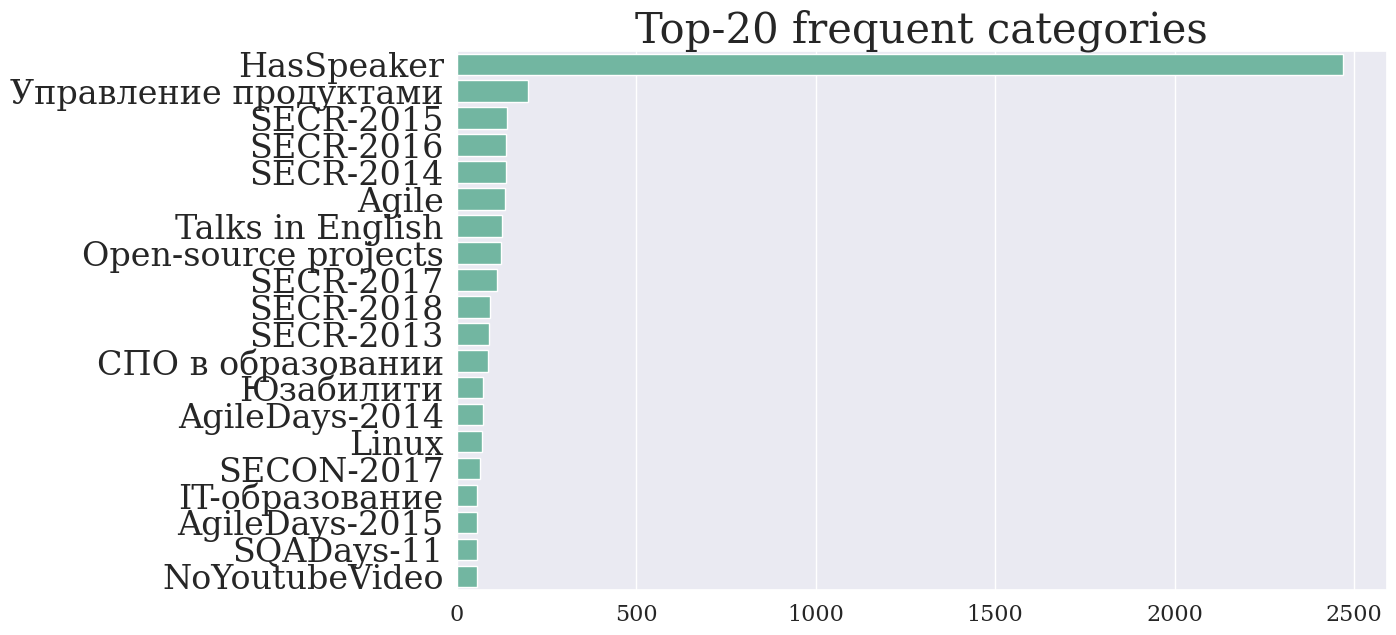

In [22]:
TOP_K = 20

sns.barplot(
    y=[x[0] for x in categories_count_values[:TOP_K]],
    x=[x[1] for x in categories_count_values[:TOP_K]],
)
plt.title(f"Top-{TOP_K} frequent categories")
plt.show()

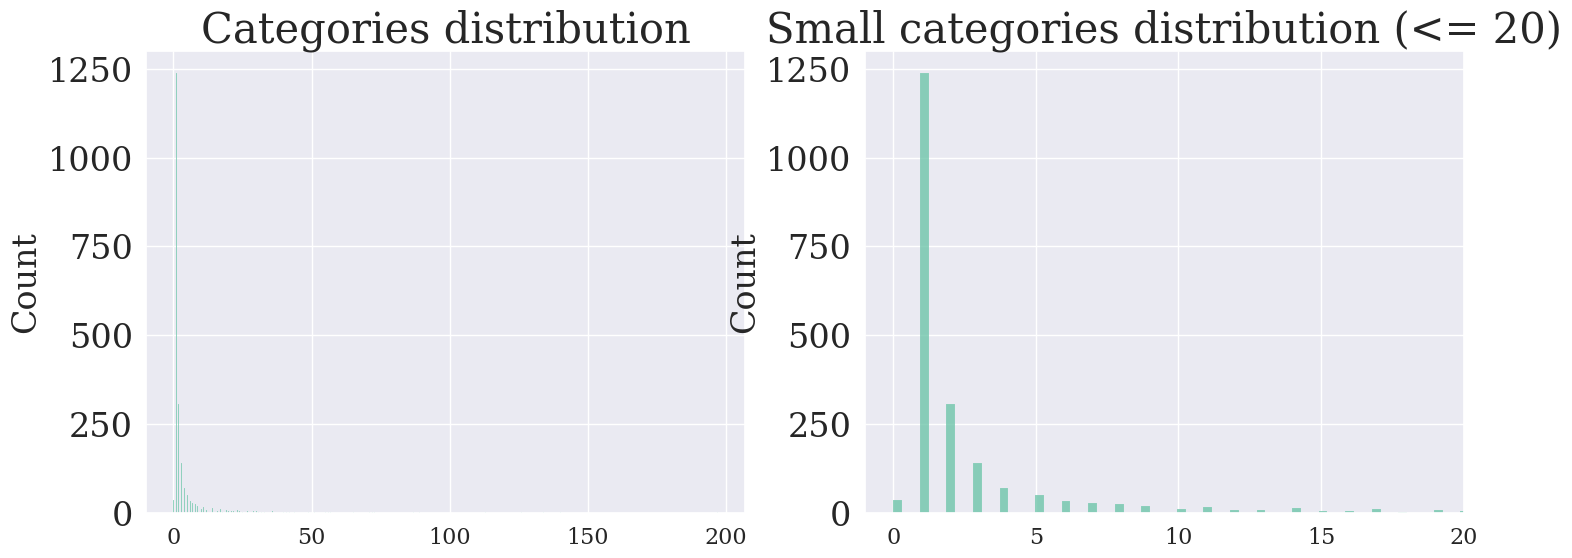

In [23]:
TOP_K = 20

fig, axes = plt.subplots(1, 2, figsize=(17, 6))
sns.histplot(x=[x[1] for x in categories_count_values[1:]], ax=axes[0])
sns.histplot(x=[x[1] for x in categories_count_values[1:]], ax=axes[1])

axes[0].set_title("Categories distribution")
axes[1].set_title(f"Small categories distribution (<= {TOP_K})")
axes[1].set_xlim(-1, 20)
plt.show()

In [24]:
pd.Series([x[1] for x in categories_count_values]).describe(percentiles=[.6, .7, .8, .9]).iloc[3:]

min       0.0
50%       1.0
60%       2.0
70%       2.0
80%       3.0
90%       8.0
max    2468.0
dtype: float64

Вывод: большинство категорий встречаются всего лишь 1 раз, предположительно -- это ФИО спикеров

Удалим вручную все имена из списка категорий + `HasSpeaker`

In [23]:
ALL_CATEGORIES_WITHOUT_NAMES = set([
    '.NET',
    '1C',
    'ALT Linux',
    'ALTLinux на Эльбрусе',
    'AR',
    'AWS',
    'Accessibility',
    'Agile',
    'Agile Introduction',
    'Agile process',
    'Agile в корпорациях',
    'Agile — технологические практики',
    'Agile&Lean Mindset',
    'Agile-культура',
    'Agile-масштабирование',
    'Agile-преобразования',
    'Alfresco',
    'Ansible',
    'Arduino',
    'AstraLinux',
    'Atlassian',
    'Azure',
    'B2B продукты',
    'BDD',
    'BigData',
    'Blockchain',
    'Bluemix',
    'Business rules engine',
    'C++',
    'CMMI',
    'CQRS',
    'CRIU',
    'Clouds',
    'Clsync',
    'Code Review',
    'Collaboration tools',
    'Configuration Management',
    'ContactOK',
    'Continuous Integration',
    'CouchDB',
    'Csharp',
    'CustisWikiToLib',
    'Customer Journey Map',
    'DDD',
    'DSL-языки',
    'Data Analysis',
    'Deployment',
    'Design Thinking',
    'DevOps',
    'Draft',
    'E-commerce',
    'Embox',
    'Erlang',
    'Extreme Programming',
    'Feature Branches',
    'Firefox',
    'Foresight management',
    'FreeIPA',
    'Front end development',
    'Fsharp',
    'GWT',
    'Glibc',
    'Go',
    'Groovy',
    'Growth Hacking',
    'HR',
    'Hardware',
    'Health',
    'High Performace Computing',
    'Highload-архитектуры',
    'IP-телефония',
    'IT-законы',
    'IT-образование',
    'Impact Map',
    'Information Security',
    'Internet of Thing',
    'Java',
    'Java EE',
    'Javascript',
    'Jenkins',
    'Kanban',
    'Knowledge Management',
    'Kotlin',
    'Kubernetes',
    'LAMP',
    'LSM',
    'LeSS',
    'Lean',
    'Lean Startup',
    'Legacy',
    'Libreoffice',
    'Linux',
    'Linux для Эльбруса',
    'Linux-дистрибутивы',
    'Linux-дистрибутивы для Enterprise',
    'Linux-обучение',
    'Lua',
    'MIPS',
    'Machine Learning',
    'Mechanics',
    'Microsoft',
    'Misc',
    'Mkimage-profiles',
    'MongoDB',
    'Morpheus',
    'MySQL',
    'NLP',
    'NOSQL',
    'NUI',
    'Natural Language Processing',
    'NeedContacts',
    'Nemerle',
    'Node.js',
    'Object Oriented Programming',
    'Open-source',
    'Open-source CAD',
    'Open-source CMS',
    'Open-source CRM',
    'Open-source ERP',
    'Open-source PAAS',
    'Open-source TCO',
    'Open-source and Community',
    'Open-source and hardware',
    'Open-source communications',
    'Open-source for Enterprise',
    'Open-source operating systems',
    'Open-source projects',
    'Open-source СУБД',
    'Open-source и законы',
    'OpenShift',
    'OpenStack',
    'OpenVZ',
    'PAAS',
    'PHP',
    'Pascale Xelot-Dugat',
    'People Management',
    'Pivot',
    'PostgreSQL',
    'ProductMeetup',
    'Python',
    'RISC-V',
    'ROSA Linux',
    'ROSALab',
    'RTOS',
    'Reviewed',
    'Riak',
    'Ruby',
    'RunaWFE',
    'SAP',
    'SELinux',
    'SOLID',
    'SVM',
    'Samba',
    'Scala',
    'Scrum',
    'Serverless',
    'Sharepoint',
    'SkillsWiki',
    'Skype',
    'Software Defined Networks',
    'Strace',
    'Support',
    'TAU-платформа',
    'TDD',
    'Talks in English',
    'Tarantool',
    'Taucraft',
    'Team Communication',
    'Teмы',
    'ToPublish',
    'Tuukka Ahoniemi',
    'UI',
    'UI SmartTV',
    'UI бизнес-приложений',
    'UX',
    'UX + Agile',
    'UX проектирование',
    'User Story',
    'VCS',
    'Visual Studio',
    'Waterfall',
    'WebRTC',
    'Windows',
    'World Usability Day',
    'ZFS',
    'Zabbix',
    'Автоматизированное тестирование',
    'Алгоритмы',
    'Анализ программ и систем',
    'Аналитика',
    'Архитектура',
    'Архитектура информационных систем',
    'Архитектура серверных приложений',
    'Аутентификация и авторизация',
    'БПЛА',
    'Базы данных',
    'Байкал',
    'Безопасность',
    'Бизнес в IT',
    'Бизнес и СПО',
    'Бизнес-анализ',
    'Блиц-доклады',
    'Веб-дизайн',
    'Веб-разработка',
    'Вебинары PingWin',
    'Верификация',
    'Видеосвязь',
    'Визуализация',
    'Виртуализация',
    'Виртуальный ассистент',
    'Встраиваемые системы',
    'Выход на зарубежные рынки',
    'Геймификация',
    'Геймификация в UX',
    'Геолокация',
    'Голосовой интерфейс',
    'Госсектор',
    'Государство и софт',
    'Графовые базы данных',
    'Диаграммы Кано',
    'Дизайн',
    'Динамический анализ',
    'Дискуссии',
    'Дискуссии о юзабилити',
    'Доверенная загрузка',
    'Доклад со стенограммой',
    'Докладчики',
    'Доклады на английском',
    'Доклады на белорусском языке',
    'Доклады на иностранных языках',
    'Доклады на украинском',
    'Документация и Agile',
    'Документирование',
    'Запуск продукта',
    'Запуск продукта в Retail',
    'Инструменты майнтейнера',
    'Инструменты майнтейнеров',
    'Инструменты разработки',
    'Информационная безопасность',
    'Информационная безопасность и СПО',
    'Информационные системы ВУЗов',
    'Использование open-source',
    'Исследовательское тестирование',
    'История из практики',
    'Картография',
    'Карьера в IT',
    'Командообразование',
    'Компиляторы',
    'Компиляция под Linux',
    'Компьютерная графика',
    'Компьютерное зрение',
    'Конференции',
    'Корпоративные решения',
    'Криптография',
    'Кроссплатформенная разработка',
    'Круглый стол',
    'Кумир',
    'Лидерство',
    'Линейки конференций',
    'Локализация',
    'Маркетинг',
    'Мастер-классы',
    'Менеджмент',
    'Метрики качества',
    'Микропрограммирование',
    'Микросервисы',
    'Мобильная разработка',
    'Моделирование бизнес-процессов',
    'Моделирование физических систем',
    'Монетизация',
    'Мониторинг',
    'Мотивация',
    'Наука',
    'Облачные сервисы',
    'Образование',
    'Обучение',
    'Обучение бизнес-анализу',
    'Обучение бизнес-процессам',
    'Обучение проектному менеджменту',
    'Обучение системному программированию',
    'Онлайн-обучение',
    'Операционные системы',
    'Оптимизация приложения',
    'Опыт внедрения СПО',
    'Организационные изменения',
    'Организационный анализ',
    'Открытые данные',
    'Отладка',
    'Оценка сотрудников',
    'Очереди',
    'Параллельное программирование',
    'Пиктомир',
    'Планирование',
    'Планирование в Agile',
    'Планировка задач',
    'Привественные речи',
    'Программирование',
    'Программная архитектура',
    'Продуктовая аналитика',
    'Прототипирование UI',
    'Процесс разработки',
    'Процесс разработки UX и UI',
    'Процесс тестирования',
    'Психология пользователя',
    'Психология разработки',
    'Разработка open-source',
    'Разработка десктоп-приложений',
    'Разработка десктопных приложений под Windows',
    'Разработка игр',
    'Разработка операционных систем',
    'Распределенные системы',
    'Редкие языки программирования',
    'Реклама',
    'Реклама компании',
    'Рекомендательные системы',
    'Ретроспектива',
    'Рефакторинг',
    'Робототехника',
    'С++',
    'САПР',
    'СПО в Госуправлении',
    'СПО в России',
    'СПО в науке',
    'СПО в образовании',
    'СПО в творчестве',
    'СПО для системного администрирования',
    'СУБД',
    'Свободные библиотеки построения графиков',
    'Свободные лицензии',
    'Сервис-ориентированная архитектура',
    'Сети',
    'Системное администрирование',
    'Системное мышление',
    'Системный анализ',
    'Системный подход',
    'Системы управления версиями',
    'Скрытые категории',
    'Собрания ALT.NET',
    'Совещания',
    'Стажировка',
    'Статический анализ кода',
    'Стратегическое планирование',
    'ТРИЗ',
    'Темы',
    'Теория ограничений',
    'Тестирование',
    'Тестирование UI',
    'Тестирование игр',
    'Тестирование мобильных приложений',
    'Тестирование производительности',
    'Технологии',
    'Технологии будущего',
    'Технологии крупных вендоров',
    'Тренды Open-source',
    'Умные вещи',
    'Управление заинтересованными сторонами',
    'Управление качеством',
    'Управление продуктами',
    'Управление рисками',
    'Управление собой',
    'Управление техподдержкой',
    'Управление требованиями',
    'Файловые системы',
    'Философия программирования',
    'Философия юзабилити',
    'Финансовые системы',
    'Фреймворки',
    'Фриланс',
    'Функциональное программирование',
    'Хранение данных',
    'Хэши',
    'Эксплуатация',
    'Эльбрус',
    'Юзабилити',
    'Юзабилити в 1C',
    'Юзабилити в играх',
    'Юзабилити интернет-магазинов',
    'Юзабилити исследования',
    'Юзабилити мобильных устройств',
    'Юзабилити образование',
    'Юзабилити поиска',
    'Юзабилити текста',
    'Языки программирования',
])

Filter child to parent categories

In [24]:
child_to_parent_categories_filt = {k: v for k,v in child_to_parent_categories.items() if k in ALL_CATEGORIES_WITHOUT_NAMES}
not_presented_categories = list(set(ALL_CATEGORIES_WITHOUT_NAMES) - set(child_to_parent_categories.keys()))

for ctgry in not_presented_categories:
    child_to_parent_categories_filt[ctgry] = []

with open('../data/child_to_parent_categories.pkl', 'wb') as fd:
    pickle.dump(child_to_parent_categories_filt, fd)

In [27]:
def coalesce(dct, keys):
    for key in keys:
        if dct[key] is not None:
            return dct[key]
    return None


def parse_document_with_categories(doc):
    parsed_doc = dict()
    parsed_doc["title"] = doc["title"]
    parsed_doc['speakers'] = speaker_detect(doc['text'])
    
    sections_data = extract_sections(doc['text'])
    parsed_doc["annotation"] = sections_data["Аннотация"]
    parsed_doc["thesis"] = coalesce(
        sections_data, ["Thesis", "Тезисы", "Расширенные тезисы"]
    )
    
    parsed_doc['raw_categories'] = clear_categories(doc["categories"])
    parsed_doc["categories"] = list(
        filter(
            lambda x: x in ALL_CATEGORIES_WITHOUT_NAMES,
            parsed_doc['raw_categories'],
        )
    )
    return parsed_doc


data_raw = [parse_document_with_categories(doc) for doc in data['articles']]

Очистка текста:
- удаление пунктуации
- удаление ссылок
- удаление всех HTML тегов
- удаление файловых расширений и всех слов, их содержащих
- удаление команд из $\LaTeX$ и Markdown
- удаление чисел как отдельных токенов (если в смычке с тексом -- то ОК)
- удаление стоп-слов
- приведение к нижнему регистру
- лемматизация (процесс приведения слова к его канонической форме или лемме; например, "better" превращается в "good")

In [29]:
# nltk.download('punkt_tab', download_dir='./nltk_data/punkt_tab')
# nltk.download('punkt', download_dir='./nltk_data/punkt')
# nltk.download('stopwords', download_dir='./nltk_data/stopwords')
# nltk.download('wordnet', download_dir='./nltk_data/wordnet')
# nltk.download('omw-1.4', download_dir='./nltk_data/omw-1.4')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
import pymorphy2

In [30]:
# Initialize stemmers and lemmatizers
english_stemmer = PorterStemmer()
english_lemmatizer = WordNetLemmatizer()
russian_stemmer = SnowballStemmer("russian")
morph = pymorphy2.MorphAnalyzer()

# Define LaTeX and Markdown command substrings to filter out
latex_markdown_commands = [
    "begin",
    "end",
    "hline",
    "hhline",
    "multicolumn",
    "label",
    "tabular",
    "centertypical",
    "fig",
    "file",
    "pgc",
    "c37",
    "c12",
    "c2",
    "c1",
    "c0k",
    "c2hline",
    "table",
    "figure",
    "section",
    "subsection",
]

# Define common file extensions to filter out
file_extensions = [
    "pdf",
    "jpg",
    "jpeg",
    "png",
    "docx",
    "xlsx",
    "bmp",
    "svg",
    "pptx",
    "txt",
    "csv",
]

latex_markdown_pattern = re.compile(
    "|".join([re.escape(cmd) for cmd in latex_markdown_commands]), re.IGNORECASE
)
file_extensions_pattern = re.compile(
    r"\b\w+\.(?:" + "|".join(file_extensions) + r")\b", re.IGNORECASE
)


def is_russian(word):
    return bool(re.search("[а-яА-Я]", word))


def clean_text(text, use_lemmatization=True):
    if text is None or len(text) == 0:
        return ""

    # Remove all HTML tags
    text = re.sub(r"<[^>]+>", "", text)

    # Remove all URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove LaTeX commands (e.g., \begin, \end)
    text = re.sub(r"\\[a-zA-Z]+", "", text)

    # Remove punctuation using regex to cover more symbols
    text = re.sub(r"[^\w\s]", "", text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Convert to lower case
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words("english") + stopwords.words("russian"))
    tokens = [word for word in tokens if word not in stop_words]

    # Drop standalone digits (keep tokens with at least one letter)
    tokens = [word for word in tokens if re.search("[A-Za-zа-яА-Я]", word)]

    cleaned_tokens = []
    for word in tokens:
        if latex_markdown_pattern.search(word):
            continue

        if file_extensions_pattern.search(word):
            continue

        if any(ext in word for ext in file_extensions):
            continue

        if use_lemmatization:
            lemmatized = (
                morph.parse(word)[0].normal_form
                if is_russian(word)
                else english_lemmatizer.lemmatize(word)
            )
            cleaned_tokens.append(lemmatized)
        else:
            cleaned_tokens.append(word)

    return " ".join(cleaned_tokens)


def clean_and_merge_document(doc):
    cleaned_texts = []

    # Clean each field and collect non-empty results
    for field in ["title", "annotation", "thesis"]:
        field_text = doc.get(field, "")
        cleaned_tokens = clean_text(field_text)

        if cleaned_tokens:
            cleaned_texts.append(cleaned_tokens)

    # Join with <sep> token
    result_text = f" {SEP_TOKEN} ".join(cleaned_texts).strip()

    result = {
        "text": result_text.split(),
        "categories": doc.get("categories", []),
        "raw_categories": doc.get("raw_categories", []),
        "speakers": doc.get("speakers", []),
    }

    return result


# Example usage
text = """
<html>Пример текста. Это тестовый текст с примером <a href="http://example.com">ссылки</a>.
Вот еще ссылка: https://www.test.ru.
Здесь есть часто-встречающиеся слова, например, "тест" много раз.
...
Также нужно удалить .эти строки.
"""
print(clean_text(text))

print(clean_and_merge_document(data_raw[1298]))

пример текст это тестовый текст пример ссылка ссылка частовстречаться слово например тест также нужно удалить строка
{'text': ['маркетинг', 'мобильный', 'приложение', 'юрий', 'мельничек', 'secr2015', '<sep>', 'руководить', 'mapsme', 'сам', 'начало', 'миллион', 'инсталляция', 'текущий', 'момент', 'это', 'время', 'сформироваться', 'системный', 'взгляд', 'маркетинг', 'мобильный', 'приложение', 'который', 'поделиться', 'слушатель', 'какой', 'существовать', 'маркетинговый', 'канал', 'раскрутка', 'мобильный', 'приложение', 'pr', 'aso', 'реклама', 'фичеринг', 'тд', 'работать', 'каждый', 'путь', 'проходить', 'пользователь', 'инсталляция', 'приложение', 'увеличить', 'конверсия', 'какой', 'инструмент', 'мобильный', 'маркетинг', 'какой', 'положение', 'маркетинг', 'бизнесстратегия', 'мобильный', 'приложение', 'доклад', 'интересный', 'маркетолог', 'топменеджер', 'разработчик', 'мобильный', 'приложение'], 'categories': ['Мобильная разработка', 'Управление продуктами'], 'raw_categories': ['HasSpeaker

Process text and count words in all documents

In [31]:
processed_data = [clean_and_merge_document(doc) for doc in data_raw]
words_counter = Counter()
 
for clear_doc in processed_data:
    words_counter.update(clear_doc['text'])

In [32]:
processed_data[:5]

[{'text': ['0mq', 'сокет', 'стероид', 'сергей', 'гулько', 'osdnua2012'],
  'categories': ['Open-source projects', 'Очереди'],
  'raw_categories': ['HasSpeaker',
   'OSDN-UA-2012',
   'Open-source projects',
   'Очереди',
   'Сергей Гулько'],
  'speakers': ['Сергей Гулько']},
 {'text': ['100ный',
   'просмотр',
   'код',
   'леонид',
   'савченков',
   'secr2013',
   '<sep>',
   'рассказать',
   'аудиторский',
   'требование',
   'изменение',
   'код',
   'должный',
   'просмотреть',
   'неавтор',
   'этот',
   'изменение',
   'банковский',
   'помочь',
   'поставить',
   'процесс',
   'просмотр',
   'код',
   'команда',
   'разработчик',
   'доклад',
   'интересный',
   'менеджер',
   'тим',
   'лида',
   'который',
   'хотеть',
   'внедрить',
   'практика',
   'code',
   'review',
   'избежать',
   'излишний',
   'сложность',
   'процесс',
   'сопротивление',
   'команда'],
  'categories': ['Code Review'],
  'raw_categories': ['Code Review',
   'HasSpeaker',
   'SECR-2013',
   'Леонид

View most common words

In [33]:
words_counter.most_common(30)

[('система', 2430),
 ('который', 2345),
 ('<sep>', 2313),
 ('проект', 1783),
 ('работа', 1567),
 ('это', 1528),
 ('разработка', 1510),
 ('доклад', 1373),
 ('использование', 1324),
 ('данные', 1208),
 ('решение', 1162),
 ('задача', 1137),
 ('процесс', 1134),
 ('такой', 1024),
 ('приложение', 961),
 ('использовать', 938),
 ('программный', 927),
 ('являться', 907),
 ('возможность', 905),
 ('проблема', 901),
 ('пользователь', 891),
 ('также', 874),
 ('время', 874),
 ('код', 852),
 ('управление', 839),
 ('программа', 837),
 ('новый', 835),
 ('компания', 834),
 ('свой', 811),
 ('продукт', 786)]

View most rare words

In [34]:
all_words_sorted = words_counter.most_common()

least_common_words = all_words_sorted[::-1]
least_common_words[:30]

[('сумасшедший', 1),
 ('катиться', 1),
 ('nomvp', 1),
 ('noprojects', 1),
 ('миксиновый', 1),
 ('функцийрасширение', 1),
 ('бреслава', 1),
 ('перегореть', 1),
 ('agileкоучий', 1),
 ('хеопёс', 1),
 ('пирамида', 1),
 ('воздвигнуть', 1),
 ('житься', 1),
 ('здорово', 1),
 ('красочный', 1),
 ('illegal', 1),
 ('liable', 1),
 ('court', 1),
 ('german', 1),
 ('battle', 1),
 ('gold', 1),
 ('jon', 1),
 ('mpl', 1),
 ('касательно', 1),
 ('beerlicense', 1),
 ('jdownloader', 1),
 ('mastercard', 1),
 ('словесный', 1),
 ('дистрибутировать', 1),
 ('сопроводить', 1)]

Есть вполне нормальные слова, у которых маленькая частота появления в тексте.

Plot counts distribution

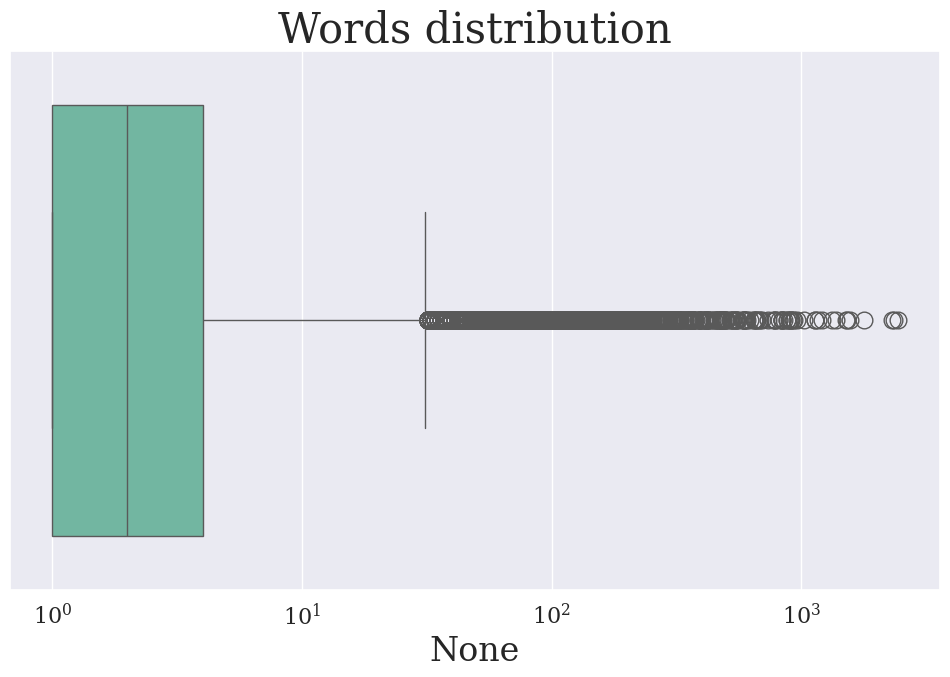

count    28952.0
mean        11.0
std         55.0
min          1.0
50%          2.0
60%          2.0
70%          3.0
80%          6.0
90%         16.0
95%         38.0
99%        177.0
max       2430.0
dtype: float64


In [35]:
counts_data = pd.Series([x[1] for x in all_words_sorted])

sns.boxplot(x=counts_data, log_scale=True)
plt.title('Words distribution')
plt.show()

print(counts_data.describe(percentiles=[.6, .7, .8, .9, .95, .99]).round())

Выкинем все слова с частотой встречи < 3 (таким образом уменьшим объём словаря на 60%)

Выкинем слова длины 1

Также удалим некоторые слова из часто-встречающихся, которые не несут смысла

In [36]:
words_to_drop = list(filter(lambda x: x[1] < 3 or len(x[0]) <= 1, all_words_sorted))

words_to_drop = list(map(lambda x: x[0], words_to_drop))
words_to_drop.extend(list(RUSSIAN_NAMES | RUSSIAN_SURNAMES | RUSSIAN_STOP_WORDS |ENG_STOP_WORDS))

processed_data_v2 = [
    {
        'text': list(filter(lambda x: x not in words_to_drop, doc['text'])),
        'categories': doc['categories'],
        'raw_categories': doc['raw_categories'],
        'speakers': doc['speakers']
    } for doc in processed_data
]

In [37]:
processed_data_v2[:5]

[{'text': ['сокет', 'стероид', 'osdnua2012'],
  'categories': ['Open-source projects', 'Очереди'],
  'raw_categories': ['HasSpeaker',
   'OSDN-UA-2012',
   'Open-source projects',
   'Очереди',
   'Сергей Гулько'],
  'speakers': ['Сергей Гулько']},
 {'text': ['просмотр',
   'код',
   'secr2013',
   '<sep>',
   'рассказать',
   'требование',
   'изменение',
   'код',
   'должный',
   'просмотреть',
   'изменение',
   'банковский',
   'помочь',
   'поставить',
   'процесс',
   'просмотр',
   'код',
   'команда',
   'разработчик',
   'доклад',
   'интересный',
   'менеджер',
   'тим',
   'лида',
   'внедрить',
   'практика',
   'code',
   'review',
   'избежать',
   'излишний',
   'сложность',
   'процесс',
   'сопротивление',
   'команда'],
  'categories': ['Code Review'],
  'raw_categories': ['Code Review',
   'HasSpeaker',
   'SECR-2013',
   'Леонид Савченков'],
  'speakers': ['Леонид Савченков']},
 {'text': ['шаг',
   'хороший',
   'качество',
   'код',
   'приёмочный',
   'тест',
   

Распределение размера документов / количества токенов

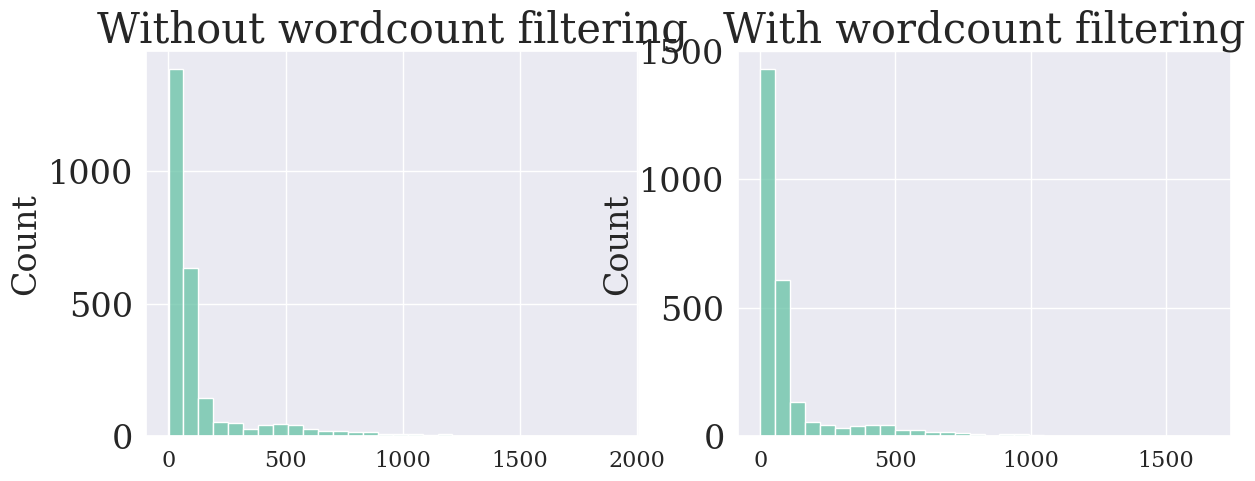

In [38]:
text_size_arr = [len(doc['text']) for doc in processed_data]
text_size_arr_v2 = [len(doc['text']) for doc in processed_data_v2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(text_size_arr, ax=axes[0], bins=30)
sns.histplot(text_size_arr_v2, ax=axes[1], bins=30)

axes[0].set_title('Without wordcount filtering')
axes[1].set_title('With wordcount filtering')

plt.show()

In [39]:
print('Unique words count before filtering:', counts_data.size)
print('Unique words count after filtering:', counts_data.size - len(words_to_drop))

percentiles_list = [.1, .2, .3, .4, .6, .7, .8, .9]
before_vs_after_df = pd.DataFrame({
    'Before': pd.Series(text_size_arr).describe(percentiles=percentiles_list).iloc[1:],
    'After': pd.Series(text_size_arr_v2).describe(percentiles=percentiles_list).iloc[1:],
})
before_vs_after_df.drop(index=['std'], inplace=True)
before_vs_after_df = before_vs_after_df.round().astype(int)
before_vs_after_df

Unique words count before filtering: 28952
Unique words count after filtering: 9508


Before  After
mean     124    105
min        1      0
10%        7      5
20%       12      9
30%       34     28
40%       47     38
50%       58     49
60%       73     60
70%       93     79
80%      132    110
90%      372    309
max     1913   1659

Save two versions: without and with wordcount filtering

Почему сохраняем две версии: отфильтрованная версия -- для классических методов построения эмбеддингов (tf-idf), а полная -- для нейросетевых методов (ruBert)

In [40]:
df_2 = pd.DataFrame(processed_data_v2)
df_2.to_parquet('../data/processed_data_v2.parquet', index=False)

Save vocabulary and word_counter

In [41]:
filtered_vocab = list(set(list(map(lambda x: x[0], all_words_sorted))) - set(words_to_drop))

with open('../data/vocab.txt', 'w') as fd:
    fd.write('\n'.join(filtered_vocab))